# Load Data/Models, Perform Clustering

In [1]:
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'CS231N_project'
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Mounted at /content/drive




## Import libraries 

In [2]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn.functional as F
import torchvision.io as io

import seaborn as sns

from PIL import Image

from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchsummary import summary

from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix

from PIL import Image



USE_GPU = True
dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


## Prepare the image transformations

In [3]:
# Training data will have some random data transformation steps to help prevent
# overfitting, these are not necessary during validation
image_transforms = {
    'train': transforms.Compose([
        transforms.CenterCrop(size=256),
        transforms.Resize(size=224),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.CenterCrop(size=256),                         
        transforms.Resize(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.CenterCrop(size=256),                         
        transforms.Resize(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}


## Prepare the DataLoaders for the road quality classification task

In [5]:
### INSERT YOUR DIRECTORY PATHS HERE ###
### -------------------------------- ###
train_directory = '/content/drive/MyDrive/CS231N_project/train_cond'
valid_directory = '/content/drive/MyDrive/CS231N_project/val_cond'
test_directory = '/content/drive/MyDrive/CS231N_project/test_cond'
### -------------------------------- ###

# Batch size
bs = 200

# Number of classes ("poor", "fair", "good")
num_classes = 3

# Load data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid']),
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

# Size of data, to be used for calculating average Loss and accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

# Create iterators for the data loaded using DataLoader module
train_data = DataLoader(data['train'], batch_size=bs, shuffle=True)
valid_data = DataLoader(data['valid'], batch_size=bs, shuffle=True)
test_data = DataLoader(data['test'], batch_size=bs, shuffle=True)

# Print the train, validation and test set data sizes
train_data_size, valid_data_size, test_data_size


(2247, 456, 4995)

## Download and modify pretrained models

The first two models we propose use a pretrained of ResNet50 pretrained on the ImageNet dataset and modify the final fully connected layers to produce our 3 class scores.

In [6]:
# Load pretrained ResNet50 Model
resnet50 = models.resnet50(pretrained=True)

# Freeze model parameters
for param in resnet50.parameters():
    param.requires_grad = False

# Modify the final layer
fc_inputs = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Linear(256, 3)
)

model_CE = copy.deepcopy(resnet50)
model_ORD = copy.deepcopy(resnet50)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Lastly, ensure that our models are on the GPU and read through the summary to ensure that we have the correct architecture

In [7]:
model_CE = model_CE.to(device=device)
model_ORD = model_ORD.to(device=device)

In [8]:
summary(model_CE, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## Load models if already trained (skip run training loops)

In [9]:
model_CE.load_state_dict(torch.load('/content/drive/MyDrive/CS231N_project/resnet50_CE.pth', map_location=torch.device('cpu')))
model_ORD.load_state_dict(torch.load('/content/drive/MyDrive/CS231N_project/resnet50_ORD.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

## Visualize T-SNE plots

In [10]:
global view_embeds
def hook_fn(model, input, output):
    global view_embeds
    view_embeds = output

def get_embeddings(model, data_loader):
    with torch.no_grad():
        # Set to evaluation mode
        model.eval()
        hook = model.fc[1].register_forward_hook(hook_fn)
        for j, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Use the forward hook to extract the embeddings
            outputs = model(inputs)
            if j == 0:
                embeds_full = view_embeds
                labels_full = labels
            else:
                embeds_full = torch.concat((embeds_full, view_embeds))
                labels_full = torch.concat((labels_full, labels))

        embeds_full = embeds_full.to(device)
        labels_full = labels_full.to(device)
        embeds_full = embeds_full.cpu().detach().numpy()
        labels_full = labels_full.cpu().detach().numpy()
        hook.remove()
        return (embeds_full, labels_full)

In [11]:
def cross_entropy_preds(outputs):
    ret, predictions = torch.max(outputs.data, 1)
    return predictions

In [12]:
def ordinal_regression_preds(outputs):
    """Convert ordinal predictions to class labels, e.g.
    [0.9, 0.1, 0.1, 0.1] -> 0
    [0.9, 0.9, 0.1, 0.1] -> 1
    [0.9, 0.9, 0.9, 0.1] -> 2
    """
    return (outputs > 0.5).cumprod(axis=1).sum(axis=1) - 1

In [13]:
global view_embeds
def hook_fn(model, input, output):
    global view_embeds
    view_embeds = output

def get_embeddings_test(model, data_loader, predict_func):
    with torch.no_grad():
        # Set to evaluation mode
        model.eval()
        hook = model.fc[1].register_forward_hook(hook_fn)
        for j, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)          
            # Use the forward hook to extract the embeddings
            outputs = model(inputs)
            predictions = predict_func(outputs.data)
            if j == 0:
                embeds_full = view_embeds
                labels_full = labels
                predictions_full = predictions
            else:
                embeds_full = torch.concat((embeds_full, view_embeds))
                labels_full = torch.concat((labels_full, labels))
                predictions_full = torch.concat((predictions_full, predictions))

        embeds_full = embeds_full.to(device)
        labels_full = labels_full.to(device)
        embeds_full = embeds_full.cpu().detach().numpy()
        labels_full = labels_full.cpu().detach().numpy()
        predictions_full = predictions_full.to(device)
        predictions_full = predictions_full.cpu().detach().numpy()
        hook.remove()
        return (embeds_full, predictions_full)

In [14]:
train_embeds_CE, train_labels_CE = get_embeddings(model_CE, train_data)
train_embeds_ORD, train_labels_ORD = get_embeddings(model_ORD, train_data)

valid_embeds_CE, valid_labels_CE = get_embeddings(model_CE, valid_data)
valid_embeds_ORD, valid_labels_ORD = get_embeddings(model_ORD, valid_data)


In [25]:
test_embeds_CE, test_preds_CE = get_embeddings_test(model_CE, test_data, cross_entropy_preds)
test_embeds_ORD, test_preds_ORD = get_embeddings_test(model_ORD, test_data, ordinal_regression_preds)

###Train CE

In [99]:
df = pd.DataFrame(train_embeds_CE)
m = TSNE(learning_rate = 50, init = 'random')
tsne_features = m.fit_transform(df)

In [100]:
df['x'] = tsne_features[:,0]
df['y'] = tsne_features[:,1]
df['road_quality'] = train_labels_CE

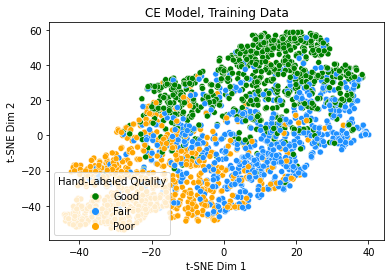

In [101]:
from pickle import TRUE
sns.scatterplot(x = "x", y = "y", hue = "road_quality", palette=['green','dodgerblue','orange'], data = df).set(title='CE Model, Training Data')
plt.xlabel('t-SNE Dim 1')
plt.ylabel('t-SNE Dim 2')
plt.legend(title='Hand-Labeled Quality', labels=['Good', 'Fair', 'Poor'], loc='lower left')
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[0].set_color('green')
leg.legendHandles[1].set_color('dodgerblue')
leg.legendHandles[2].set_color('orange')


###Train ORD

In [96]:
df = pd.DataFrame(train_embeds_ORD)
m = TSNE(learning_rate = 50, init = 'random')
tsne_features = m.fit_transform(df)

In [97]:
df['x'] = tsne_features[:,0]
df['y'] = tsne_features[:,1]
df['road_quality'] = train_labels_ORD

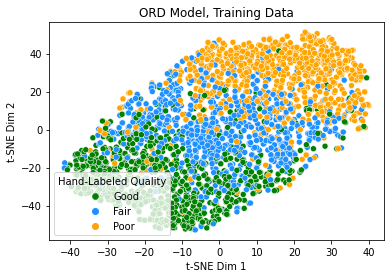

In [98]:
sns.scatterplot(x = "x", y = "y", hue = "road_quality", palette=['green','dodgerblue','orange'], data = df).set(title='ORD Model, Training Data')
plt.xlabel('t-SNE Dim 1')
plt.ylabel('t-SNE Dim 2')
plt.legend(title='Hand-Labeled Quality', labels=['Good', 'Fair', 'Poor'], loc='lower left')
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[0].set_color('green')
leg.legendHandles[1].set_color('dodgerblue')
leg.legendHandles[2].set_color('orange')
plt.show()

###Valid CE

In [93]:
df = pd.DataFrame(valid_embeds_CE)
m = TSNE(learning_rate = 50, init = 'random')
tsne_features = m.fit_transform(df)

In [94]:
df['x'] = tsne_features[:,0]
df['y'] = tsne_features[:,1]
df['road_quality'] = valid_labels_CE

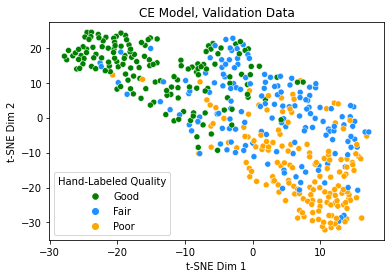

In [95]:
sns.scatterplot(x = "x", y = "y", hue = "road_quality", palette=['green','dodgerblue','orange'], data = df).set(title='CE Model, Validation Data')
plt.xlabel('t-SNE Dim 1')
plt.ylabel('t-SNE Dim 2')
plt.legend(title='Hand-Labeled Quality', labels=['Good', 'Fair', 'Poor'], loc='lower left')
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[0].set_color('green')
leg.legendHandles[1].set_color('dodgerblue')
leg.legendHandles[2].set_color('orange')
plt.show()

###Valid ORD

In [90]:
df = pd.DataFrame(valid_embeds_ORD)
m = TSNE(learning_rate = 50, init = 'random')
tsne_features = m.fit_transform(df)

In [91]:
df['x'] = tsne_features[:,0]
df['y'] = tsne_features[:,1]
df['road_quality'] = valid_labels_ORD

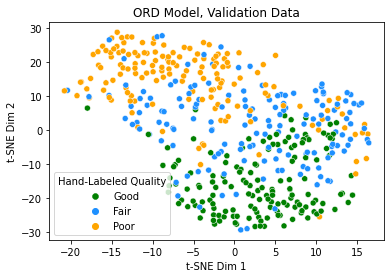

In [92]:
sns.scatterplot(x = "x", y = "y", hue = "road_quality", palette=['green','dodgerblue','orange'], data = df).set(title='ORD Model, Validation Data')
plt.xlabel('t-SNE Dim 1')
plt.ylabel('t-SNE Dim 2')
plt.legend(title='Hand-Labeled Quality', labels=['Good', 'Fair', 'Poor'], loc='lower left')
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[0].set_color('green')
leg.legendHandles[1].set_color('dodgerblue')
leg.legendHandles[2].set_color('orange')
plt.show()

###Test CE

In [87]:
df = pd.DataFrame(test_embeds_CE)
m = TSNE(learning_rate = 50, init = 'random')
tsne_features = m.fit_transform(df)

In [88]:
df['x'] = tsne_features[:,0]
df['y'] = tsne_features[:,1]
df['road_quality'] = test_preds_CE

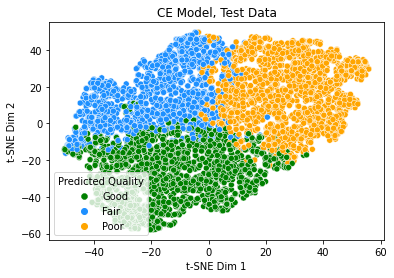

In [89]:
sns.scatterplot(x = "x", y = "y", hue = "road_quality", palette=['green','dodgerblue','orange'], data = df).set(title='CE Model, Test Data')
plt.xlabel('t-SNE Dim 1')
plt.ylabel('t-SNE Dim 2')
plt.legend(title='Predicted Quality', labels=['Good', 'Fair', 'Poor'], loc='lower left')
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[0].set_color('green')
leg.legendHandles[1].set_color('dodgerblue')
leg.legendHandles[2].set_color('orange')
plt.show()

###Test ORD

In [78]:
df = pd.DataFrame(test_embeds_ORD)
m = TSNE(learning_rate = 50, init = 'random')
tsne_features = m.fit_transform(df)

In [79]:
df['x'] = tsne_features[:,0]
df['y'] = tsne_features[:,1]
df['road_quality'] = test_preds_ORD

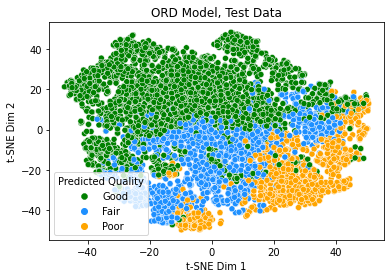

In [86]:
sns.scatterplot(x = "x", y = "y", hue = "road_quality", palette=['green','dodgerblue','orange'], data = df).set(title='ORD Model, Test Data')
plt.xlabel('t-SNE Dim 1')
plt.ylabel('t-SNE Dim 2')
plt.legend(title='Predicted Quality', labels=['Good', 'Fair', 'Poor'], loc='lower left')
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[0].set_color('green')
leg.legendHandles[1].set_color('dodgerblue')
leg.legendHandles[2].set_color('orange')
plt.show()